In [1]:
import pandas as pd
import spacy
from spacy import displacy
import numpy as np
import pickle as pk
import json

In [2]:
nlp = spacy.load('en_core_web_sm')

In [3]:
df = pd.read_csv("./data/df_indian_dishoom_reviews_train.csv")

In [4]:
df.head(5)

,rating,review,sentiment
0,5,Yah it was good. \nI am always skeptical but w...,1
1,4,TIMING:\n - Got in line at 5pm on a Saturday...,1
2,3,varunmurali.com/blog/dis…\nIrani cafes have th...,-1
3,4,Dishoom is a beloved string of modern Indian r...,1
4,4,One does not go to London without going to the...,1


In [5]:
ex=10
print (df["review"][ex])
print ("----------")
doc = nlp(df["review"][ex])  # 2nd sentence
for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
          [child for child in token.children])

Came for breakfast after a quick flight in from Zurich -- excellent food, and an interesting middle ground between boring/traditional English breakfast food and Dishoom style.  I had the bacon naan sandwich (which was excellent) and fried eggs on chili cheese toast (also great), plus a breakfast lassi and espresso.  Probably the best breakfast I've had in Europe.  Unsurprisingly the restaurant is still packed even at 9am in a weekday.
----------
Came ROOT Came VERB [for, after, .]
for prep Came VERB [breakfast]
breakfast pobj for ADP []
after prep Came VERB [flight]
a det flight NOUN []
quick amod flight NOUN []
flight pobj after ADP [a, quick, in]
in prep flight NOUN [from]
from prep in ADP [Zurich]
Zurich pobj from ADP [--, food]
-- punct Zurich PROPN []
excellent amod food NOUN []
food appos Zurich PROPN [excellent, ,, and, ground]
, punct food NOUN []
and cc food NOUN []
an det ground NOUN []
interesting amod ground NOUN []
middle amod ground NOUN []
ground conj food NOUN [an, inte

In [6]:
displacy.render(doc, style='dep', jupyter=True, options = { 'distance':80 })

In [7]:
sentt = []
for idno, sentence in enumerate(doc.sents):
    print ('Sentence {}:'.format(idno + 1), sentence)
    sentt.append(sentence)
doc_1 = sentt[1]  # let's use this statement for further analysis

Sentence 1: Came for breakfast after a quick flight in from Zurich -- excellent food, and an interesting middle ground between boring/traditional English breakfast food and Dishoom style.  
Sentence 2: I had the bacon naan sandwich (which was excellent) and fried eggs on chili cheese toast (also great), plus a breakfast lassi and espresso.  
Sentence 3: Probably the best breakfast I've had in Europe.  
Sentence 4: Unsurprisingly the restaurant is still packed even at 9am in a weekday.


In [8]:
displacy.render(doc_1, style='dep', jupyter=True, options = { 'distance':80 })

In [9]:
def getRoot(sentence):
    depy=[]
    print ("Input sentence is: " + str(sentence))
    for tok in sentence:
        dep =  (tok.text, tok.dep_, "---> ", tok.head.text)
        print (dep)
        depy.append(dep)
    root = list(filter(lambda x : x[1]=="ROOT", depy))
    if len(root) == 0 : return 999
    return root
  #  print (possible_subject, possible_subject.dep_, possible_subject.head.pos_)
  #  if possible_subject.dep == "nsubj" and possible_subject.head.pos == "VERB":
  #      verbs.add(possible_subject.head)

doc = "John likes an apple"
for sentence in nlp(doc).sents:
    root = getRoot(sentence)
print ("The root is :" + str(root))

Input sentence is: John likes an apple
('John', 'nsubj', '---> ', 'likes')
('likes', 'ROOT', '---> ', 'likes')
('an', 'det', '---> ', 'apple')
('apple', 'dobj', '---> ', 'likes')
The root is :[('likes', 'ROOT', '---> ', 'likes')]


In [10]:
def getTriples(root, sentence):
    depy=[]
    #print (root)
    for tok in sentence:  # tokenize it again
        dep =  (tok.text, tok.dep_, "---> ", tok.head.text)
        depy.append(dep)
    subj = list(filter(lambda x : x[1]=="nsubj", depy))
    #print (subj)
    obj = list(filter(lambda x : x[1]=="dobj", depy))
    #print (obj)
    #print ("root is" + str(root))
    try: 
        triples = (subj[0][0], root[0][0], obj[0][0])
    except IndexError:
        print ("Grammar incorrect. No triples for " + str(sentence))
        print ("Grammar is " + str(depy))
        return None
    return triples

triples=[]
doc = "John likes big apple. The apple tastes delicious."
#doing it sentence by sentence
for sentence in nlp(doc).sents:
    root = getRoot(sentence)  # obtain root of one sentence
    if root != 999 : 
        triple = getTriples(root, sentence)  # obtain triples in that sentence
        print ("Triple is " + str(triple))
   # triples.append(triple)

Input sentence is: John likes big apple.
('John', 'nsubj', '---> ', 'likes')
('likes', 'ROOT', '---> ', 'likes')
('big', 'amod', '---> ', 'apple')
('apple', 'dobj', '---> ', 'likes')
('.', 'punct', '---> ', 'likes')
Triple is ('John', 'likes', 'apple')
Input sentence is: The apple tastes delicious.
('The', 'det', '---> ', 'apple')
('apple', 'nsubj', '---> ', 'tastes')
('tastes', 'ROOT', '---> ', 'tastes')
('delicious', 'dobj', '---> ', 'tastes')
('.', 'punct', '---> ', 'tastes')
Triple is ('apple', 'tastes', 'delicious')


In [11]:
# entity & aspect categories
# From Frequency approach
aspect = {
    "food": [
        "noodles", "food", "dumplings", "dumpling", "pork", "flavour", "chili", "duck",    
        "dishes", "dish", "lunch", "bun", "shrimp", "dimsum", "rice", "chicken", "soup", "chow",
        "msg", "tea", "meal", "drink", "drinks", "eat", "delish", "tasted", "taste", "daal",
        "naan", "flavorful", "tasty", "murgh", "malai", "ruby", "chops", "sandwich",
        "toast", "espresso", "lassi", "breakfast", "breakfasts", "dinner", "cocktails", "cocktail", "whiskey",
        "vegetarian", "biryani", "delicious", "kulfi", "dessert", "desserts", "cuisine", "lentils", "cooked",
        "cook", "seasoned", "kebab", "potatoes", "potato", "lamb", "onion", "onions", "bao", 
        "dim", "cognac", "mai", "bun", "beef", "macaroons", "macaroon"
    ],
    "service" : [
        "staff", "workers", "waiter", "rude", "wait", "waited", "waiting", "water", "queue", "service", 
        "seated", "turn away", "experience", "reservations", "reservation", "bartender"
    ],
    "ambience": [
        "furniture", "bathroom", "decoration", "floors", "tables", "table", "seat", "seating", "flatware",
        "decor", "ambience", "vibe", "crowded", "loud", "ambiance", "design", "interior", "chic", "modern",
        "atmosphere"
    ],
    "price" : ["price", "prices", "priced", "cost", "cheap", "cheaper", "expensive"]
}
# overall : will be everything else    
# Helper function for categorising aspects:
def aspectCat(sentence):
    category=[]
    for tok in sentence:
        tok = tok.text.lower()
        for key, val in aspect.items():
            if tok in val: category.append(key)
    if len(category) == 0 : category.append("overall")
    return category

In [12]:
reviews_sent =[] 
# reloading vectoriser & svm classifier
# note it is important that the classifier is trained on the vectoriser and so is the test set
vectorizer = pk.load(open("./models/vectorise.pk","rb"))
classifier_svm = pk.load(open("./models/classifier_svm.pk", "rb"))  # load the previously trained SVM classifier

def getSentiment(span):
    res = 0.0
    # print (span)
    test_transform = vectorizer.transform([span.text])
    res=classifier_svm.predict(test_transform)
    # print(res)
    return res

ex=200
doc = nlp(df["review"][ex])
for idx, sentence in enumerate(doc.sents):
    # print(sentence)
    res = getSentiment(sentence)
    try:
        cat = aspectCat(sentence)      
        reviews_sent.append({"scores":list(res), "text":sentence, "category":cat})
    except IndexError:
        # there are no specific aspects talked about. Just in general
        reviews_sent.append({"scores":list(res), "text":sentence, "category":"overall"})
print(reviews_sent)

/Users/davidleonardi/anaconda3/lib/python3.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.1 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/davidleonardi/anaconda3/lib/python3.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.1 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/davidleonardi/anaconda3/lib/python3.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator SVC from version 0.19.1 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


[{'scores': [1], 'text': Returned to Dishoom after an excellent experience several years ago., 'category': ['service']}, {'scores': [1], 'text': I decided to forgo the dinner wait and go for lunch on my first afternoon in London., 'category': ['food', 'service', 'food']}, {'scores': [1], 'text': Quality of the food is still impressive and the drink I had at the bar while I waited for my table also didn't disappoint., 'category': ['food', 'food', 'service', 'ambience']}, {'scores': [1], 'text': Will probably make this a regular stop whenever I visit London, if only so I can try other items off the menu., 'category': ['overall']}]


In [13]:
reviews = {}
for i in range(len(df["review"])):
    doc = nlp(df["review"][i])
    reviews_sent =[] 
    for idx, sentence in enumerate(doc.sents):
        #print (sentence)
        res = str(getSentiment(sentence))
        try:
            cat = aspectCat(sentence)      
            reviews_sent.append({"scores":res, "text":sentence.text, "category":cat})
        except IndexError:
            reviews_sent.append({"scores":res, "text":sentence.text, "category":"overall"})
    reviews[i]=reviews_sent

# set of all reviews
fname = "./data/dependency_parsing/dp_indian_dishoom_reviews.json"
ffile = open(fname, "w")
json.dump(reviews, ffile)
ffile.close()
#print (reviews)

print ("-----------")

# summarise all reviews
summary_scores = {"overall":[], "service":[], "price":[], "food":[], "ambience": []}
# count total no of 
for key, val in reviews.items():
    #print (val)
    for i in val:
        score = eval(i["scores"])[0]
        summary_scores[i["category"][0]].append(score)

# print (summary_scores)
for key, val in summary_scores.items():
    #avg = round(np.mean(val),2)
    pos = np.sum(np.array(val) >= 0, axis=0)
    neg = np.sum(np.array(val) < 0, axis=0)
   # print (val)
   # try:
   #     nb = len(val)
   # except TypeError                                  :
    #    nb = 1
    summary_scores[key]={"pos":pos,"neg": neg, "nb talked": pos + neg}
#summary_scores["total no of reviews"]=len(reviews)
print (summary_scores)
df_summary = pd.DataFrame(summary_scores)

-----------
{'overall': {'pos': 3172, 'neg': 1696, 'nb talked': 4868}, 'service': {'pos': 1183, 'neg': 601, 'nb talked': 1784}, 'price': {'pos': 79, 'neg': 66, 'nb talked': 145}, 'food': {'pos': 3568, 'neg': 1045, 'nb talked': 4613}, 'ambience': {'pos': 343, 'neg': 170, 'nb talked': 513}}


In [14]:
df_summary = pd.DataFrame(summary_scores )

df_summary=df_summary.transpose()
df_summary.columns=[ "total", "negative", "positive"]
df_summary["category"] = df_summary.index
df_summary.append(pd.Series([1,2,3,"dummy"]),ignore_index = True)
print(df_summary)

          total  negative  positive  category
overall    4868      1696      3172   overall
service    1784       601      1183   service
price       145        66        79     price
food       4613      1045      3568      food
ambience    513       170       343  ambience


          total  negative  positive  category
price       145        66        79     price
ambience    513       170       343  ambience
service    1784       601      1183   service
food       4613      1045      3568      food
overall    4868      1696      3172   overall


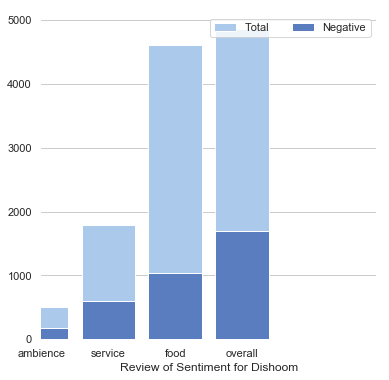

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 6))
df_summary = df_summary.sort_values("total")
print(df_summary)
# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="category", y="total", data=df_summary,
            label="Total", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="category", y="negative", data=df_summary,
            label="Negative", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(xlim=(1, 6), ylabel="",
       xlabel="Review of Sentiment for Dishoom")
sns.despine(left=True, bottom=True)